In [1]:
# %%
# ## ResNet50 Fine-Tuning on Food-11
# Multiclass classification (11 classes)
# Includes confusion matrix & F1-score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:

# %%
# Configuration
writer = SummaryWriter(log_dir='runs/food11_resnet50')
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_classes = 11
num_epochs = 10
batch_size = 64
val_split = 0.2

train_dir = 'food11/train'
test_dir = 'food11/test'

Using device: cpu


In [3]:

# %%
# Data transforms
input_size = 224
train_tf = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.CenterCrop((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [4]:

# %%
# Dataset split
full_dataset = datasets.ImageFolder(train_dir)
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)
split = int(val_split*len(full_dataset))
train_idx, val_idx = indices[split:], indices[:split]

train_dataset = Subset(datasets.ImageFolder(train_dir, transform=train_tf), train_idx)
val_dataset = Subset(datasets.ImageFolder(train_dir, transform=val_tf), val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:

# %%
# Load pre-trained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for name, param in model.named_parameters():
    if "layer2" not in name and "layer3" not in name and "layer4" not in name and "fc" not in name:
        param.requires_grad = False  # замораживаем
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # new classifier
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/nikitaradcenko/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100.0%


In [6]:

# %%
# Training & evaluation functions
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss/len(dataloader.dataset), running_corrects.double()/len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()*images.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return running_loss/len(dataloader.dataset), running_corrects.double()/len(dataloader.dataset), all_labels, all_preds

In [7]:

# %%
# Training loop
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    v_loss, v_acc, val_labels, val_preds = evaluate(model, val_loader, criterion)
    
    train_losses.append(tr_loss)
    val_losses.append(v_loss)
    train_accs.append(tr_acc.item())
    val_accs.append(v_acc.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train acc: {tr_acc:.3f}, Val acc: {v_acc:.3f}")
    
    # TensorBoard logging
    writer.add_scalar('ResNet50/Train_Loss', tr_loss, epoch)
    writer.add_scalar('ResNet50/Val_Loss', v_loss, epoch)
    writer.add_scalar('ResNet50/Train_Acc', tr_acc, epoch)
    writer.add_scalar('ResNet50/Val_Acc', v_acc, epoch)

writer.close()



Epoch [1/10] -> Train acc: 0.205, Val acc: 0.294
Epoch [2/10] -> Train acc: 0.347, Val acc: 0.384
Epoch [3/10] -> Train acc: 0.426, Val acc: 0.474
Epoch [4/10] -> Train acc: 0.483, Val acc: 0.493
Epoch [5/10] -> Train acc: 0.540, Val acc: 0.441
Epoch [6/10] -> Train acc: 0.571, Val acc: 0.547
Epoch [7/10] -> Train acc: 0.607, Val acc: 0.473
Epoch [8/10] -> Train acc: 0.623, Val acc: 0.532
Epoch [9/10] -> Train acc: 0.641, Val acc: 0.572
Epoch [10/10] -> Train acc: 0.659, Val acc: 0.610


ResNet50 F1-score (macro) on val set: 0.6019


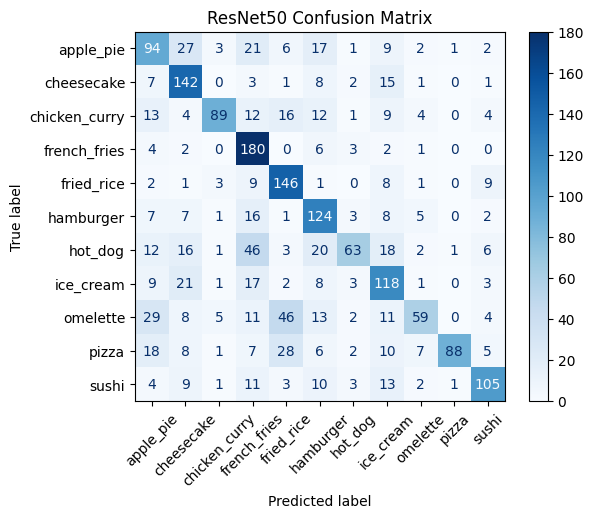

In [8]:

# Confusion Matrix & F1-score
cm = confusion_matrix(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds, average='macro')
print(f"ResNet50 F1-score (macro) on val set: {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("ResNet50 Confusion Matrix")
plt.show()
